# 🛰️ <b> <u> <font color='YELLOW'> 1. IMPORTs </font>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numpy import sin, cos, exp, sign
import numpy as np
import matplotlib as mpl
import itertools as it
from scipy import integrate
from matplotlib import rc
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "monospaced"
})
plt.rc('axes', labelsize=12)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

In [2]:
from math import ceil
def get_idx_from_vals(maxv, minv, step, value):
    '''
        Konwertuje wartość zmiennej na jej indeks w odpowiadającej jej tablicy
        np. x_arr = [1.2, 1.4, 1.6, 1.8]
            get_idx_from_vals(1.4) >>> returns: idx = 1 
    '''
    arr_len = (maxv - minv) / step + 1
    slope = (arr_len - 1) / (maxv - minv)
    idx = lambda elem: ceil(slope*(elem - minv))
    
    idx = ceil(slope*(value - minv))
    
    return idx


In [3]:
# import matplotlib 
# matplotlib.rc('xtick', labelsize=20) 
# matplotlib.rc('ytick', labelsize=20) 

# ☄️<b> <u>  <font color='YELLOW'> 2. Model Params

In [4]:
##### Model params #####
M = 0.815
mp = 0.21
mc = 0
Lp = 0.305
Lc = 2*Lp
g = 9.8145
mr = mp+mc
Mt = M+mr
L = (Lp*mp + Lc*mc) / mr
Jcm = 1/12*mp*Lp**2
Jt = Jcm + mr*L**2
gamma = 0.1
b_lepkie = 2.1
b_stribeck = 3
miu_c      = 0.04287
miu_s      = 0.0861
vs         = 0.105
i          = 2
delta      = 400
D = 0
u = 0 
c1 = 1.719
c2 = 7.682

In [5]:
# params viscous
params_visc = [M, mc, mp, Lp, Lc, g, b_lepkie, gamma, mr, Mt, L, Jcm, Jt]
# params stribeck
params_stri = [M, mc, mp, Lp, Lc, g, b_stribeck, gamma, mr, Mt, L, Jcm, Jt, miu_c, miu_s, vs, i]

# ☄️<b> <u>  <font color='YELLOW'> 3. Functions for numerical simulation

## <b> <font color='yellow'> 3.1 Viscous friction

In [6]:
# Viscous friction nonlinear model
def state_eqs_viscous_model_nonlin(params):
    ''' x1, x2, x3, x4 = x, theta, Dx, Dtheta '''
    M, mc, mp, Lp, Lc, g, b, gamma, mr, Mt, L, Jcm, Jt = params
    
    def ddt_x1(x1, x2, x3, x4):
        return x3
    def ddt_x2(x1, x2, x3, x4):
        return x4
    def ddt_x3(x1, x2, x3, x4):
        u = 0
        D = 0
        den = Jt*Mt - ( L*mr*cos(x2) )**2
        Ff = b*x3
        ret = ( Jt*(D*cos(x2) - Ff + L*mr*(x4**2)*sin(x2) + u) - \
               L*mr*cos(x2)*(D*Lc + L*g*mr*sin(x2) - gamma*x4) ) / den
        return ret
    
    def ddt_x4(x1, x2, x3, x4):
        u = 0
        den = Jt*Mt - ( L*mr*cos(x2) )**2
        Ff = b*x3
        ret = ( -L*mr*cos(x2)*(D*cos(x2) - Ff + L*mr*(x4**2)*sin(x2) + u) + \
               Mt*(D*Lc + L*g*mr*sin(x2) - gamma*x4) ) / den
        return ret

    return (ddt_x1, ddt_x2, ddt_x3, ddt_x4) 

# Viscous friction, linear model, up postion
def state_eqs_viscous_model_lin_up(params):
    M, mc, mp, Lp, Lc, g, b, gamma, mr, Mt, L, Jcm, Jt = params
    
    def ddt_x1(x1, x2, x3, x4):
        return x3
    def ddt_x2(x1, x2, x3, x4):
        return x4
    def ddt_x3(x1, x2, x3, x4):
        u = 0
        D = 0
        den = Jt*Mt - (L*mr)**2
        ret = (L*mr*gamma*x4 - Jt*b*x3 - x2*g*(L*mr)**2) / den
        return ret
    
    def ddt_x4(x1, x2, x3, x4):
        u = 0
        D = 0
        den = Jt*Mt - (L*mr)**2
        ret = (L*Mt*g*mr*x2 + L*b*mr*x3 - Mt*gamma*x4) / den
        return ret

    return (ddt_x1, ddt_x2, ddt_x3, ddt_x4) 

def state_eqs_viscous_model_lin_down(params):
    M, mc, mp, Lp, Lc, g, b, gamma, mr, Mt, L, Jcm, Jt = params
    
    def ddt_x1(x1, x2, x3, x4):
        return x3
    def ddt_x2(x1, x2, x3, x4):
        return x4
    def ddt_x3(x1, x2, x3, x4):
        u = 0
        D = 0
        den = Jt*Mt - (L*mr)**2
        ret = (-L*mr*gamma*x4 - Jt*b*x3 - x2*g*(L*mr)**2) / den
        return ret
    
    def ddt_x4(x1, x2, x3, x4):
        u = 0
        D = 0
        den = Jt*Mt - (L*mr)**2
        ret = (-L*Mt*g*mr*x2 - L*b*mr*x3 - Mt*gamma*x4) / den
        return ret

    return (ddt_x1, ddt_x2, ddt_x3, ddt_x4) 

## <b> <font color='yellow'> 3.2 Stribeck friction

In [7]:
# Stribeck friction, nonlinear model
def state_eqs_stribeck_model_nonlin(params):
    ''' x1, x2, x3, x4 = x, theta, Dx, Dtheta '''
    M, mc, mp, Lp, Lc, g, b, gamma, mr, Mt, L, Jcm, Jt, miu_c, miu_s, vs, i = params
    
    def ddt_x1(x1, x2, x3, x4):
        return x3
    def ddt_x2(x1, x2, x3, x4):
        return x4
    def ddt_x3(x1, x2, x3, x4):
        u = 0
        D = 0
        den = Jt*Mt - ( L*mr*cos(x2) )**2
        Ff = Mt*g*(miu_c + (miu_s - miu_c)*exp(-(x3/vs)**i)) * np.tanh(400*x3) + b*x3
        ret = ( Jt*(D*cos(x2) - Ff + L*mr*(x4**2)*sin(x2) + u) - \
               L*mr*cos(x2)*(D*Lc + L*g*mr*sin(x2) - gamma*x4) ) / den
        return ret
    
    def ddt_x4(x1, x2, x3, x4):
        u = 0
        den = Jt*Mt - ( L*mr*cos(x2) )**2
        Ff = b*x3
        ret = ( -L*mr*cos(x2)*(D*cos(x2) - Ff + L*mr*(x4**2)*sin(x2) + u) + \
               Mt*(D*Lc + L*g*mr*sin(x2) - gamma*x4) ) / den
        return ret

    return (ddt_x1, ddt_x2, ddt_x3, ddt_x4) 

# Stribeck ffriction, linear model, up position
def state_eqs_stribeck_model_lin_up(params):
    M, mc, mp, Lp, Lc, g, b, gamma, mr, Mt, L, Jcm, Jt, miu_c, miu_s, vs, i = params
    
    def ddt_x1(x1, x2, x3, x4):
        return x3
    def ddt_x2(x1, x2, x3, x4):
        return x4
    def ddt_x3(x1, x2, x3, x4):
        u = 0
        D = 0
        den = Jt*Mt - (L*mr)**2
        ret = (L*mr*gamma*x4 - Jt*x3*(400*Mt*g*miu_s+b) - x2*g*(L*mr)**2) / den
        return ret
    
    def ddt_x4(x1, x2, x3, x4):
        u = 0
        D = 0
        den = Jt*Mt - (L*mr)**2
        ret = (L*Mt*g*mr*x2 + L*mr*x3*(400*Mt*g*miu_s+b) - Mt*gamma*x4) / den
        return ret

    return (ddt_x1, ddt_x2, ddt_x3, ddt_x4) 

def state_eqs_stribeck_model_lin_down(params):
    M, mc, mp, Lp, Lc, g, b, gamma, mr, Mt, L, Jcm, Jt, miu_c, miu_s, vs, i = params
    
    def ddt_x1(x1, x2, x3, x4):
        return x3
    def ddt_x2(x1, x2, x3, x4):
        return x4
    def ddt_x3(x1, x2, x3, x4):
        u = 0
        D = 0
        den = Jt*Mt - (L*mr)**2
        ret = (-L*mr*gamma*x4 - Jt*x3*400*Mt*g*miu_s - x2*g*(L*mr)**2 - Jt*b*x3) / den
        return ret
    
    def ddt_x4(x1, x2, x3, x4):
        u = 0
        D = 0
        den = Jt*Mt - (L*mr)**2
        ret = (-L*Mt*g*mr*x2 - 400*L*Mt*g*mr*miu_s*x3 - L*b*mr*x3 - Mt*gamma*x4) / den
        return ret


    return (ddt_x1, ddt_x2, ddt_x3, ddt_x4) 

# ☄️<b> <u>  <font color='YELLOW'> 4. Images

In [8]:
########################################################################
x_min, x_max        = (0, 1) # bez sensu ale niech jest
deg_theta_min_max   = np.array([-150, 250])
Dx_min, Dx_max      = (-5, 6)   
deg_Dtheta_min_max  = np.array([-350, 350])

x_step          = 1
deg_theta_step  = 10
Dx_step         = 1
deg_Dtheta_step = 10
# ################################################################

grid_tick_step  = 25    # choose appropriately with xlim and ylim
scale = 5 # scales the vectors after normalization

save_fig = 1
fig_dpi = 175

#####################################################################
# x values at wchich to slice 4D vector field
x_value = 0

## <b> <font color='yellow'> 4.1 Viscous friction, up and down

In [10]:
# deg -> rad
rad_theta_step      = deg_theta_step        * np.pi/180
rad_Dtheta_step     = deg_Dtheta_step       * np.pi/180
rad_theta_min_max   = deg_theta_min_max     * np.pi/180
rad_Dtheta_min_max  = deg_Dtheta_min_max    * np.pi/180

x_coord             = np.arange(x_min, x_max+x_step, x_step)                                                            # x 
theta_coord_rad     = np.arange(rad_theta_min_max[0], rad_theta_min_max[1]+rad_theta_step, rad_theta_step)              # theta
Dx_coord            = np.arange(Dx_min, Dx_max+Dx_step, Dx_step)                                                        # Dx
Dtheta_coord_rad    = np.arange(rad_Dtheta_min_max[0], rad_Dtheta_min_max[1]+rad_Dtheta_step, rad_Dtheta_step)          # Dtheta

# Coordinate matrices in radians, 4 axes for each state variable
x_cmat, theta_cmat, Dx_cmat, D_theta_cmat = np.meshgrid(x_coord, theta_coord_rad, Dx_coord, Dtheta_coord_rad, indexing='ij')

d_x1_f, d_x2_f, d_x3_f, d_x4_f = state_eqs_viscous_model_nonlin(params=params_visc)
d_x1_f_u, d_x2_f_u, d_x3_f_u, d_x4_f_u = state_eqs_viscous_model_lin_up(params=params_visc)
d_x1_f_d, d_x2_f_d, d_x3_f_d, d_x4_f_d = state_eqs_viscous_model_lin_down(params=params_visc)

dir_x       = d_x1_f(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_theta   = d_x2_f(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_Dx      = d_x3_f(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_Dtheta  = d_x4_f(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)

dir_x_u       = d_x1_f_u(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_theta_u   = d_x2_f_u(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_Dx_u      = d_x3_f_u(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_Dtheta_u  = d_x4_f_u(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)

dir_x_d       = d_x1_f_d(x_cmat, theta_cmat-np.pi, Dx_cmat, D_theta_cmat)
dir_theta_d   = d_x2_f_d(x_cmat, theta_cmat-np.pi, Dx_cmat, D_theta_cmat)
dir_Dx_d      = d_x3_f_d(x_cmat, theta_cmat-np.pi, Dx_cmat, D_theta_cmat)
dir_Dtheta_d  = d_x4_f_d(x_cmat, theta_cmat-np.pi, Dx_cmat, D_theta_cmat)

# rad -> deg
theta_cmat      = theta_cmat * 180/np.pi
D_theta_cmat    = D_theta_cmat* 180/np.pi
dir_theta       = dir_theta * 180/np.pi
dir_Dtheta      = dir_Dtheta * 180/np.pi

Tarcie lepkie, linearyzacja góra


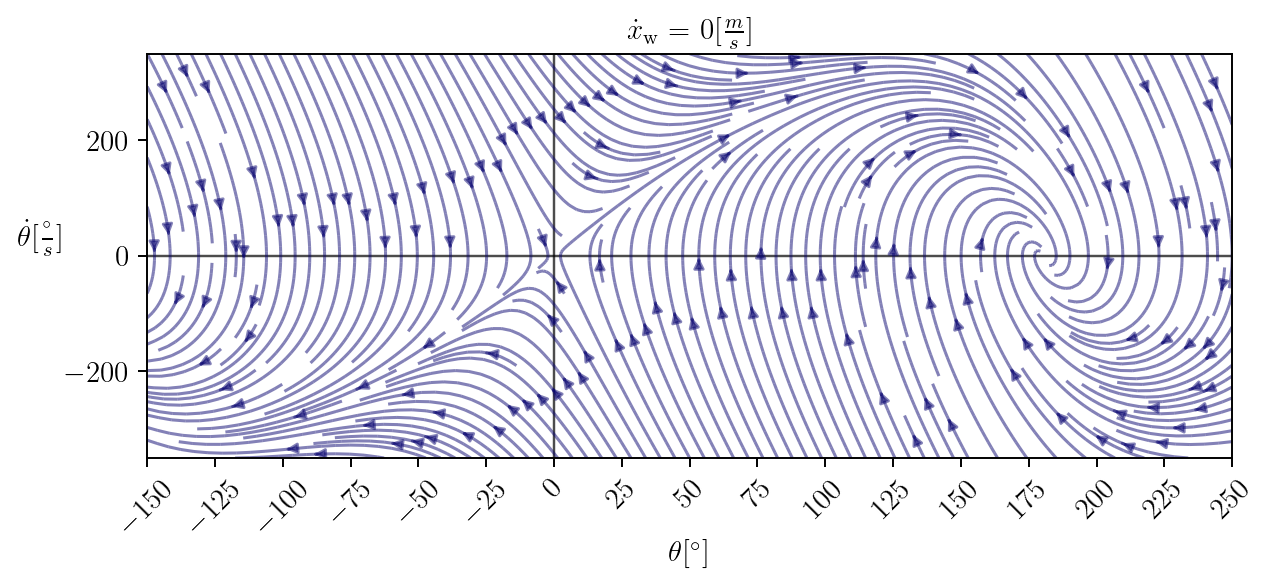

In [12]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(8, 3), dpi=fig_dpi, sharey=True, sharex=True)

xlabel=r'$\theta [ ^\circ ]$'
ylabel=r'$\dot{\theta} [\frac{^\circ}{s}]$'

ax.set_ylabel(ylabel, labelpad=10, rotation=0)     
ax.set_xlabel(xlabel, labelpad=0)

ax.hlines(y=0, xmin=deg_theta_min_max[0], xmax=deg_theta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
ax.vlines(x=0, ymin=deg_Dtheta_min_max[0], ymax=deg_Dtheta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
ax.set_xlim(deg_theta_min_max)
ax.set_ylim(deg_Dtheta_min_max)

ax.xaxis.set_ticks([i for i in np.arange(deg_theta_min_max[0], deg_theta_min_max[1]+grid_tick_step, grid_tick_step)])
# ax.set_yticks([i for i in np.arange(deg_Dtheta_min_max[0], deg_Dtheta_min_max[1]+grid_tick_step,  grid_tick_step)])
ax.tick_params(axis='x', rotation=45)

#####################################################################
# dla Dx
# Dx = Dx_values[0]
Dx = 0
Dx_idx = get_idx_from_vals(maxv=Dx_max, minv=Dx_min, step=Dx_step, value=Dx)
ax.set_title(r'$\dot{x}_{\mathrm{w}} =\ $' + '{}'.format(Dx_coord[Dx_idx]) + r'$[\frac{m}{s}]$')

# c1 = np.array([135, 135, 135]) / 255 # kolor szary 1
c1 = np.array([8, 4, 112]) / 255
ax.streamplot(theta_cmat[x_value, :, Dx_idx, :].T,
              D_theta_cmat[x_value, :, Dx_idx, :].T,
              dir_theta[x_value, :, Dx_idx, :].T,
              dir_Dtheta[x_value, :, Dx_idx, :].T,
              density=2.5, 
              color=[*c1, 0.5],
              linewidth=1.25,
              arrowsize=0.85, 
              zorder=2,
              # maxlength=10,
              # minlength=0.4,
              broken_streamlines=True,
              # start_points = list(it.product(theta_coord_rad[:-1:8]*180/np.pi, Dtheta_coord_rad[:-1:8]*180/np.pi))
)

# gray_patch = mpatches.Patch(color=np.array([135, 135, 135]) / 255, label='Model nieliniowy')
# blck_patch = mpatches.Patch(color=[0, 0, 0], label=r'Model zlinearyzowany dla $\theta=0$')
# legend = plt.legend(handles=[gray_patch, blck_patch], loc='upper right')
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((1, 1, 1, 1))

if save_fig:
    fig.savefig(f"./PFdxw0.jpg",
                 dpi=fig_dpi,bbox_inches='tight')

Tarcie lepkie, linearyzacja góra


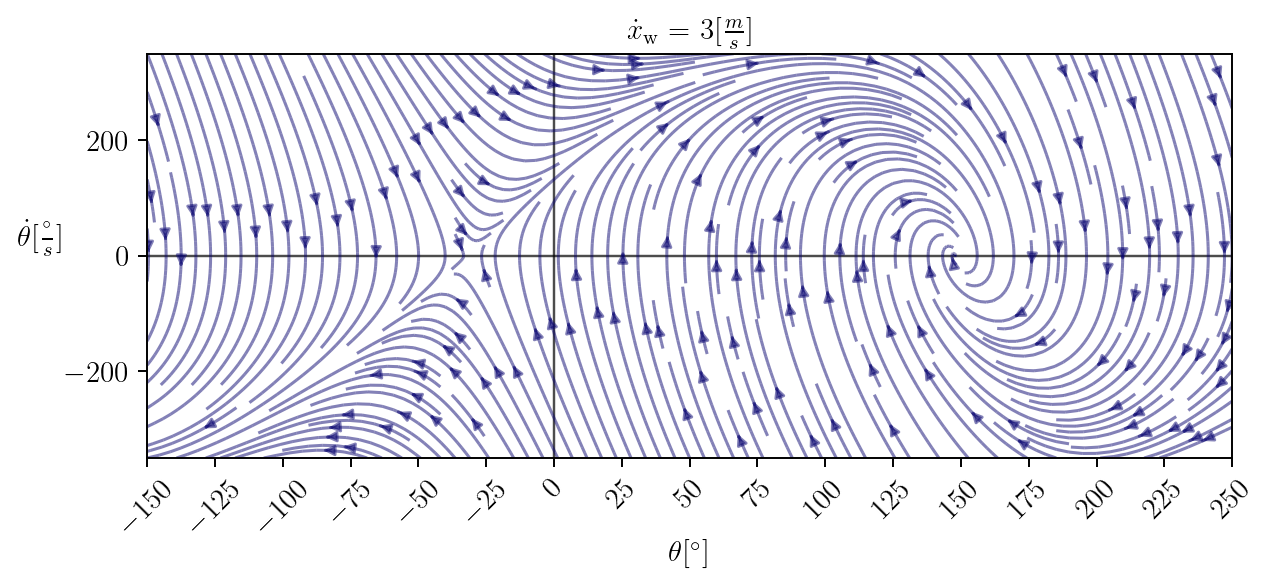

In [13]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(8, 3), dpi=fig_dpi, sharey=True, sharex=True)

xlabel=r'$\theta [ ^\circ ]$'
ylabel=r'$\dot{\theta} [\frac{^\circ}{s}]$'

ax.set_ylabel(ylabel, labelpad=10, rotation=0)     
ax.set_xlabel(xlabel, labelpad=0)

ax.hlines(y=0, xmin=deg_theta_min_max[0], xmax=deg_theta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
ax.vlines(x=0, ymin=deg_Dtheta_min_max[0], ymax=deg_Dtheta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
ax.set_xlim(deg_theta_min_max)
ax.set_ylim(deg_Dtheta_min_max)

ax.xaxis.set_ticks([i for i in np.arange(deg_theta_min_max[0], deg_theta_min_max[1]+grid_tick_step, grid_tick_step)])
# ax.set_yticks([i for i in np.arange(deg_Dtheta_min_max[0], deg_Dtheta_min_max[1]+grid_tick_step,  grid_tick_step)])
ax.tick_params(axis='x', rotation=45)

#####################################################################
# dla Dx
# Dx = Dx_values[0]
Dx = 3
Dx_idx = get_idx_from_vals(maxv=Dx_max, minv=Dx_min, step=Dx_step, value=Dx)
ax.set_title(r'$\dot{x}_{\mathrm{w}} =\ $' + '{}'.format(Dx_coord[Dx_idx]) + r'$[\frac{m}{s}]$')

c1 = np.array([8, 4, 112]) / 255
ax.streamplot(theta_cmat[x_value, :, Dx_idx, :].T,
              D_theta_cmat[x_value, :, Dx_idx, :].T,
              dir_theta[x_value, :, Dx_idx, :].T,
              dir_Dtheta[x_value, :, Dx_idx, :].T,
              density=2.5, 
              color=[*c1, 0.5],
              linewidth=1.25,
              arrowsize=0.85, 
              zorder=2,
              # maxlength=10,
              # minlength=0.4,
              broken_streamlines=True,
              # start_points = list(it.product(theta_coord_rad[:-1:8]*180/np.pi, Dtheta_coord_rad[:-1:8]*180/np.pi))
)

# gray_patch = mpatches.Patch(color=np.array([135, 135, 135]) / 255, label='Modedl nieliniowy')
# blck_patch = mpatches.Patch(color=[0, 0, 0], label=r'Model zlinearyzowany dla $\theta = 0$')
# legend = plt.legend(handles=[gray_patch, blck_patch], loc='upper right')
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((1, 1, 1, 1))
if save_fig:
    fig.savefig(f'./PFdxw3.jpg',
                 dpi=fig_dpi,bbox_inches='tight')

Tarcie lepkie, linearyzacja góra


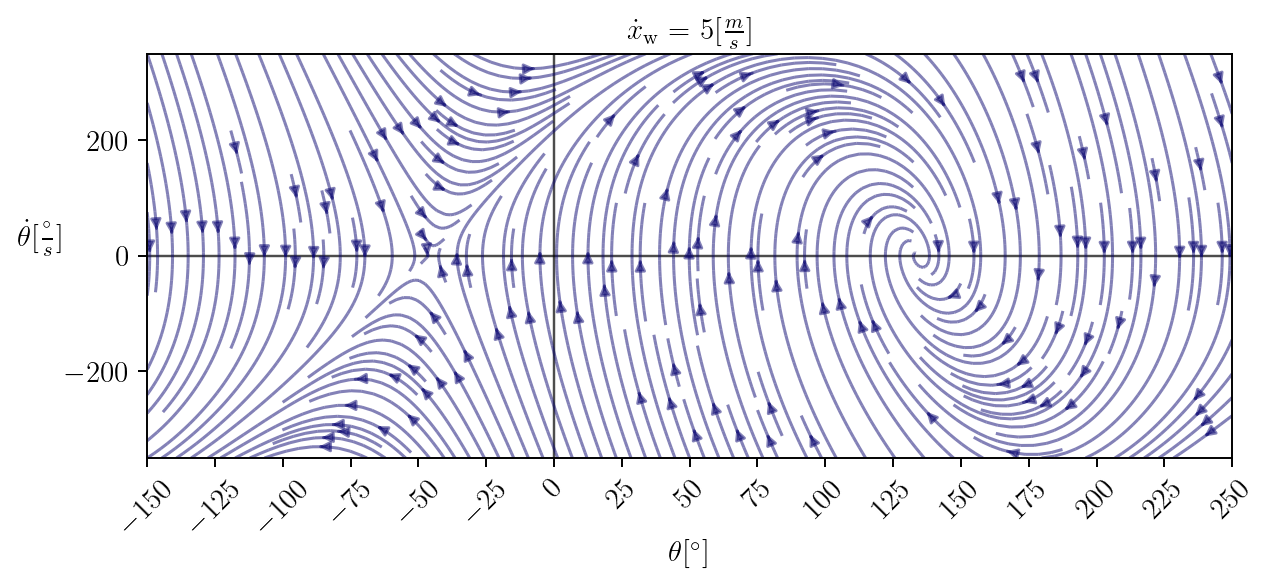

In [14]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(8, 3), dpi=fig_dpi, sharey=True, sharex=True)

xlabel=r'$\theta [ ^\circ ]$'
ylabel=r'$\dot{\theta} [\frac{^\circ}{s}]$'

ax.set_ylabel(ylabel, labelpad=10, rotation=0)     
ax.set_xlabel(xlabel, labelpad=0)

ax.hlines(y=0, xmin=deg_theta_min_max[0], xmax=deg_theta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
ax.vlines(x=0, ymin=deg_Dtheta_min_max[0], ymax=deg_Dtheta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
ax.set_xlim(deg_theta_min_max)
ax.set_ylim(deg_Dtheta_min_max)

ax.xaxis.set_ticks([i for i in np.arange(deg_theta_min_max[0], deg_theta_min_max[1]+grid_tick_step, grid_tick_step)])
# ax.set_yticks([i for i in np.arange(deg_Dtheta_min_max[0], deg_Dtheta_min_max[1]+grid_tick_step,  grid_tick_step)])
ax.tick_params(axis='x', rotation=45)

#####################################################################
# dla Dx
# Dx = Dx_values[0]
Dx = 5
Dx_idx = get_idx_from_vals(maxv=Dx_max, minv=Dx_min, step=Dx_step, value=Dx)
ax.set_title(r'$\dot{x}_{\mathrm{w}} =\ $' + '{}'.format(Dx_coord[Dx_idx]) + r'$[\frac{m}{s}]$')


c1 = np.array([8, 4, 112]) / 255
ax.streamplot(theta_cmat[x_value, :, Dx_idx, :].T,
              D_theta_cmat[x_value, :, Dx_idx, :].T,
              dir_theta[x_value, :, Dx_idx, :].T,
              dir_Dtheta[x_value, :, Dx_idx, :].T,
              density=2.5, 
              color=[*c1, 0.5],
              linewidth=1.25,
              arrowsize=0.85, 
              zorder=2,
              # maxlength=10,
              # minlength=0.4,
              broken_streamlines=True,
              # start_points = list(it.product(theta_coord_rad[:-1:8]*180/np.pi, Dtheta_coord_rad[:-1:8]*180/np.pi))
)

# gray_patch = mpatches.Patch(color=np.array([135, 135, 135]) / 255, label='Modedl nieliniowy')
# blck_patch = mpatches.Patch(color=[0, 0, 0], label=r'Model zlinearyzowany dla $\theta = 0$')
# legend = plt.legend(handles=[gray_patch, blck_patch], loc='upper right')
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((1, 1, 1, 1))

if save_fig:
    fig.savefig(f'./PFdxw5.jpg',
                 dpi=fig_dpi,bbox_inches='tight')

Tarcie lepkie, linearyzacja góra


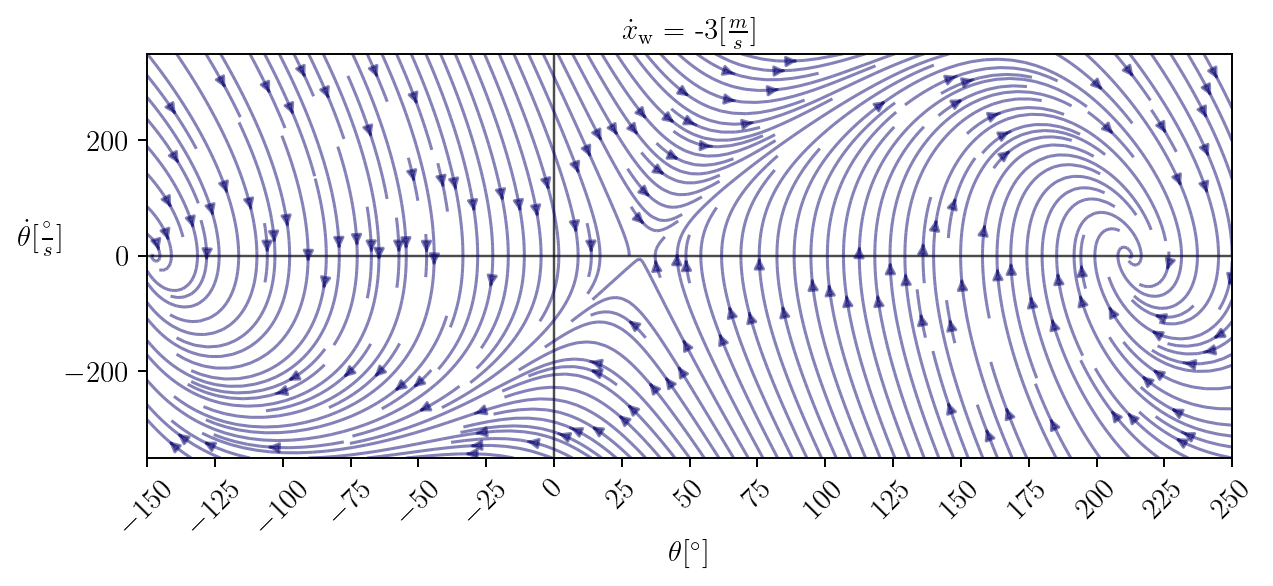

In [15]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(8, 3), dpi=fig_dpi, sharey=True, sharex=True)

xlabel=r'$\theta [ ^\circ ]$'
ylabel=r'$\dot{\theta} [\frac{^\circ}{s}]$'

ax.set_ylabel(ylabel, labelpad=10, rotation=0)     
ax.set_xlabel(xlabel, labelpad=0)

ax.hlines(y=0, xmin=deg_theta_min_max[0], xmax=deg_theta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
ax.vlines(x=0, ymin=deg_Dtheta_min_max[0], ymax=deg_Dtheta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
ax.set_xlim(deg_theta_min_max)
ax.set_ylim(deg_Dtheta_min_max)

ax.xaxis.set_ticks([i for i in np.arange(deg_theta_min_max[0], deg_theta_min_max[1]+grid_tick_step, grid_tick_step)])
# ax.set_yticks([i for i in np.arange(deg_Dtheta_min_max[0], deg_Dtheta_min_max[1]+grid_tick_step,  grid_tick_step)])
ax.tick_params(axis='x', rotation=45)

#####################################################################
# dla Dx
# Dx = Dx_values[0]
Dx = -3
Dx_idx = get_idx_from_vals(maxv=Dx_max, minv=Dx_min, step=Dx_step, value=Dx)
ax.set_title(r'$\dot{x}_{\mathrm{w}} =\ $' + '{}'.format(Dx_coord[Dx_idx]) + r'$[\frac{m}{s}]$')

c1 = np.array([8, 4, 112]) / 255
ax.streamplot(theta_cmat[x_value, :, Dx_idx, :].T,
              D_theta_cmat[x_value, :, Dx_idx, :].T,
              dir_theta[x_value, :, Dx_idx, :].T,
              dir_Dtheta[x_value, :, Dx_idx, :].T,
              density=2.5, 
              color=[*c1, 0.5],
              linewidth=1.25,
              arrowsize=0.85, 
              zorder=2,
              # maxlength=10,
              # minlength=0.4,
              broken_streamlines=True,
              # start_points = list(it.product(theta_coord_rad[:-1:8]*180/np.pi, Dtheta_coord_rad[:-1:8]*180/np.pi))
)

# gray_patch = mpatches.Patch(color=np.array([135, 135, 135]) / 255, label='Modedl nieliniowy')
# blck_patch = mpatches.Patch(color=[0, 0, 0], label=r'Model zlinearyzowany dla $\theta = 0$')
# legend = plt.legend(handles=[gray_patch, blck_patch], loc='upper right')
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((1, 1, 1, 1))

if save_fig:
    fig.savefig(f'./PFdxwm3.jpg',
                 dpi=fig_dpi,bbox_inches='tight')

Tarcie lepkie, linearyzacja góra


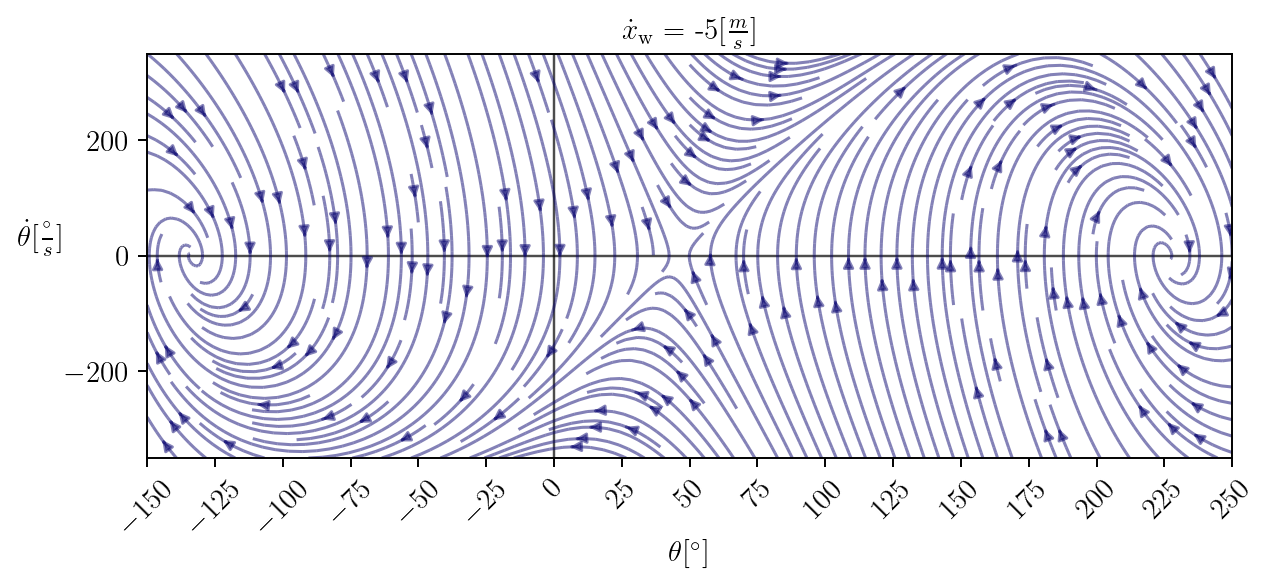

In [16]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(8, 3), dpi=fig_dpi, sharey=True, sharex=True)

xlabel=r'$\theta [ ^\circ ]$'
ylabel=r'$\dot{\theta} [\frac{^\circ}{s}]$'

ax.set_ylabel(ylabel, labelpad=10, rotation=0)     
ax.set_xlabel(xlabel, labelpad=0)

ax.hlines(y=0, xmin=deg_theta_min_max[0], xmax=deg_theta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
ax.vlines(x=0, ymin=deg_Dtheta_min_max[0], ymax=deg_Dtheta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
ax.set_xlim(deg_theta_min_max)
ax.set_ylim(deg_Dtheta_min_max)

ax.xaxis.set_ticks([i for i in np.arange(deg_theta_min_max[0], deg_theta_min_max[1]+grid_tick_step, grid_tick_step)])
# ax.set_yticks([i for i in np.arange(deg_Dtheta_min_max[0], deg_Dtheta_min_max[1]+grid_tick_step,  grid_tick_step)])
ax.tick_params(axis='x', rotation=45)

# dla Dx
# Dx = Dx_values[0]
Dx = -5
Dx_idx = get_idx_from_vals(maxv=Dx_max, minv=Dx_min, step=Dx_step, value=Dx)
ax.set_title(r'$\dot{x}_{\mathrm{w}} =\ $' + '{}'.format(Dx_coord[Dx_idx]) + r'$[\frac{m}{s}]$')

c1 = np.array([8, 4, 112]) / 255
ax.streamplot(theta_cmat[x_value, :, Dx_idx, :].T,
              D_theta_cmat[x_value, :, Dx_idx, :].T,
              dir_theta[x_value, :, Dx_idx, :].T,
              dir_Dtheta[x_value, :, Dx_idx, :].T,
              density=2.5, 
              color=[*c1, 0.5],
              linewidth=1.25,
              arrowsize=0.85, 
              zorder=2,
              # maxlength=10,
              # minlength=0.4,
              broken_streamlines=True,
              # start_points = list(it.product(theta_coord_rad[:-1:8]*180/np.pi, Dtheta_coord_rad[:-1:8]*180/np.pi))
)

# gray_patch = mpatches.Patch(color=np.array([135, 135, 135]) / 255, label='Modedl nieliniowy')
# blck_patch = mpatches.Patch(color=[0, 0, 0], label=r'Model zlinearyzowany dla $\theta = 0$')
# legend = plt.legend(handles=[gray_patch, blck_patch], loc='upper right')
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((1, 1, 1, 1))

if save_fig:
    fig.savefig(f'./PFdxwm5.jpg',
                 dpi=fig_dpi,bbox_inches='tight')

## <b> <font color='yellow'> 4.2 Stribeck friction, down position

In [18]:
# deg -> rad
rad_theta_step      = deg_theta_step        * np.pi/180
rad_Dtheta_step     = deg_Dtheta_step       * np.pi/180
rad_theta_min_max   = deg_theta_min_max     * np.pi/180
rad_Dtheta_min_max  = deg_Dtheta_min_max    * np.pi/180

x_coord             = np.arange(x_min, x_max+x_step, x_step)                                                            # x 
theta_coord_rad     = np.arange(rad_theta_min_max[0], rad_theta_min_max[1]+rad_theta_step, rad_theta_step)              # theta
Dx_coord            = np.arange(Dx_min, Dx_max+Dx_step, Dx_step)                                                        # Dx
Dtheta_coord_rad    = np.arange(rad_Dtheta_min_max[0], rad_Dtheta_min_max[1]+rad_Dtheta_step, rad_Dtheta_step)          # Dtheta

# Coordinate matrices in radians, 4 axes for each state variable
x_cmat, theta_cmat, Dx_cmat, D_theta_cmat = np.meshgrid(x_coord, theta_coord_rad, Dx_coord, Dtheta_coord_rad, indexing='ij')

state_eqs_stribeck_model_nonlin
state_eqs_stribeck_model_lin_up
state_eqs_stribeck_model_lin_down

d_x1_f, d_x2_f, d_x3_f, d_x4_f = state_eqs_stribeck_model_nonlin(params=params_stri)
d_x1_f_u, d_x2_f_u, d_x3_f_u, d_x4_f_u = state_eqs_stribeck_model_lin_up(params=params_stri)
d_x1_f_d, d_x2_f_d, d_x3_f_d, d_x4_f_d = state_eqs_stribeck_model_lin_down(params=params_stri)

dir_x       = d_x1_f(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_theta   = d_x2_f(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_Dx      = d_x3_f(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_Dtheta  = d_x4_f(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)

dir_x_u       = d_x1_f_u(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_theta_u   = d_x2_f_u(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_Dx_u      = d_x3_f_u(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)
dir_Dtheta_u  = d_x4_f_u(x_cmat, theta_cmat, Dx_cmat, D_theta_cmat)

dir_x_d       = d_x1_f_d(x_cmat, theta_cmat-np.pi, Dx_cmat, D_theta_cmat)
dir_theta_d   = d_x2_f_d(x_cmat, theta_cmat-np.pi, Dx_cmat, D_theta_cmat)
dir_Dx_d      = d_x3_f_d(x_cmat, theta_cmat-np.pi, Dx_cmat, D_theta_cmat)
dir_Dtheta_d  = d_x4_f_d(x_cmat, theta_cmat-np.pi, Dx_cmat, D_theta_cmat)

# rad -> deg
theta_cmat      = theta_cmat * 180/np.pi
D_theta_cmat    = D_theta_cmat* 180/np.pi
dir_theta       = dir_theta * 180/np.pi
dir_Dtheta      = dir_Dtheta * 180/np.pi

Tarcie Stribecka, linearyzacja góra


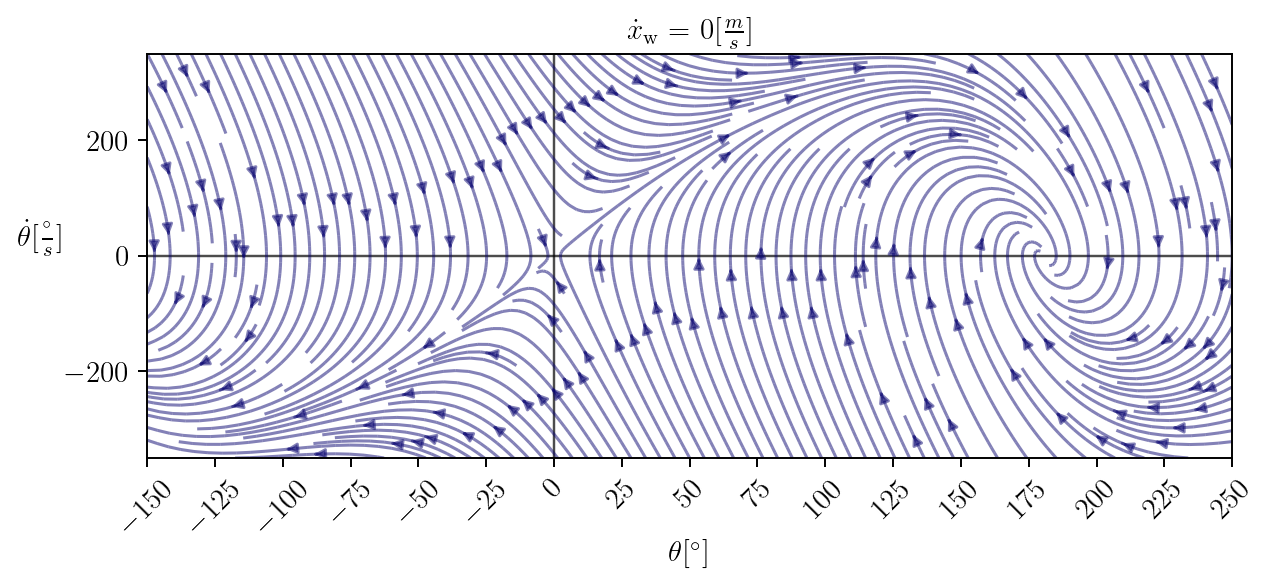

In [20]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(8, 3), dpi=fig_dpi, sharey=True, sharex=True)

xlabel=r'$\theta [ ^\circ ]$'
ylabel=r'$\dot{\theta} [\frac{^\circ}{s}]$'

ax.set_ylabel(ylabel, labelpad=10, rotation=0)     
ax.set_xlabel(xlabel, labelpad=0)

ax.hlines(y=0, xmin=deg_theta_min_max[0], xmax=deg_theta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
ax.vlines(x=0, ymin=deg_Dtheta_min_max[0], ymax=deg_Dtheta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
ax.set_xlim(deg_theta_min_max)
ax.set_ylim(deg_Dtheta_min_max)

ax.xaxis.set_ticks([i for i in np.arange(deg_theta_min_max[0], deg_theta_min_max[1]+grid_tick_step, grid_tick_step)])
# ax.set_yticks([i for i in np.arange(deg_Dtheta_min_max[0], deg_Dtheta_min_max[1]+grid_tick_step,  grid_tick_step)])
ax.tick_params(axis='x', rotation=45)

#####################################################################
# dla Dx
# Dx = Dx_values[0]
Dx = 0
Dx_idx = get_idx_from_vals(maxv=Dx_max, minv=Dx_min, step=Dx_step, value=Dx)
ax.set_title(r'$\dot{x}_{\mathrm{w}} =\ $' + '{}'.format(Dx_coord[Dx_idx]) + r'$[\frac{m}{s}]$')

c1 = np.array([8, 4, 112]) / 255
ax.streamplot(theta_cmat[x_value, :, Dx_idx, :].T,
              D_theta_cmat[x_value, :, Dx_idx, :].T,
              dir_theta[x_value, :, Dx_idx, :].T,
              dir_Dtheta[x_value, :, Dx_idx, :].T,
              density=2.5, 
              color=[*c1, 0.5],
              linewidth=1.25,
              arrowsize=0.85, 
              zorder=2,
              # maxlength=10,
              # minlength=0.4,
              broken_streamlines=True,
              # start_points = list(it.product(theta_coord_rad[:-1:8]*180/np.pi, Dtheta_coord_rad[:-1:8]*180/np.pi))
)

# gray_patch = mpatches.Patch(color=np.array([135, 135, 135]) / 255, label='Model nieliniowy')
# blck_patch = mpatches.Patch(color=[0, 0, 0], label=r'Model zlinearyzowany dla $\theta=0$')
# legend = plt.legend(handles=[gray_patch, blck_patch], loc='upper right')
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((1, 1, 1, 1))

if save_fig:
    fig.savefig(f'./PFdxw0_strib.jpg',
                 dpi=fig_dpi,bbox_inches='tight')

In [21]:
# tarcie stribecka linearyzacja dół

In [22]:
# fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(8, 3), dpi=fig_dpi, sharey=True, sharex=True)

# xlabel=r'$\theta [ ^\circ ]$'
# ylabel=r'$\dot{\theta} [\frac{^\circ}{s}]$'

# ax.set_ylabel(ylabel, labelpad=10, rotation=0)     
# ax.set_xlabel(xlabel, labelpad=0)

# ax.hlines(y=0, xmin=deg_theta_min_max[0], xmax=deg_theta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
# ax.vlines(x=0, ymin=deg_Dtheta_min_max[0], ymax=deg_Dtheta_min_max[1], colors='black', linestyles='-', linewidth=1, alpha=0.7)
# ax.set_xlim(deg_theta_min_max)
# ax.set_ylim(deg_Dtheta_min_max)

# ax.xaxis.set_ticks([i for i in np.arange(deg_theta_min_max[0], deg_theta_min_max[1]+grid_tick_step, grid_tick_step)])
# # ax.set_yticks([i for i in np.arange(deg_Dtheta_min_max[0], deg_Dtheta_min_max[1]+grid_tick_step,  grid_tick_step)])
# ax.tick_params(axis='x', rotation=45)

# #####################################################################
# # to można zrobic w for loop-ie, iterować po tablicy z wartościami
# # dla Dx
# # Dx = Dx_values[0]
# Dx = 0
# Dx_idx = get_idx_from_vals(maxv=Dx_max, minv=Dx_min, step=Dx_step, value=Dx)
# ax.set_title(r'$\dot{x}_{\mathrm{w}} =\ $' + '{}'.format(Dx_coord[Dx_idx]) + r'$[\frac{m}{s}]$')

# # te liczby powinny być takie same albo bardzo blisko siebie
# # print( Dx_coord[Dx_idx] )
# # print( Dx )
# # print()
# print("Tarcie Stribecka, linearyzacja góra")
# c1 = np.array([8, 4, 112]) / 255
# ax.streamplot(theta_cmat[x_value, :, Dx_idx, :].T,
#               D_theta_cmat[x_value, :, Dx_idx, :].T,
#               dir_theta[x_value, :, Dx_idx, :].T,
#               dir_Dtheta[x_value, :, Dx_idx, :].T,
#               density=2.5, 
#               color=[*c1, 0.5],
#               linewidth=1.25,
#               arrowsize=0.85, 
#               zorder=2,
#               # maxlength=10,
#               # minlength=0.4,
#               broken_streamlines=True,
#               # start_points = list(it.product(theta_coord_rad[:-1:8]*180/np.pi, Dtheta_coord_rad[:-1:8]*180/np.pi))
# )

# # # do legendy
# # gray_patch = mpatches.Patch(color=np.array([135, 135, 135]) / 255, label='Model nieliniowy')
# # blck_patch = mpatches.Patch(color=[0, 0, 0], label=r'Model zlinearyzowany dla $\theta=\pi$')
# # legend = plt.legend(handles=[gray_patch, blck_patch], loc='upper right')
# # legend.get_frame().set_alpha(None)
# # legend.get_frame().set_facecolor((1, 1, 1, 1))

# if save_fig:
#     fig.savefig(f'./12.jpg',
#                  dpi=fig_dpi,bbox_inches='tight')